In [1]:
import json
from urllib.request import urlopen
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
%matplotlib inline

In [2]:
api_url = "https://data.cityofnewyork.us/resource/qiz3-axqb.csv?"
field_list = [
    "date,time,",
    "latitude,longitude,",
    "borough,cross_street_name,on_street_name,off_street_name,",
    "number_of_cyclist_injured,number_of_cyclist_killed,",
    "number_of_pedestrians_injured,number_of_pedestrians_killed,",
    "contributing_factor_vehicle_1,contributing_factor_vehicle_2,",
    "vehicle_type_code1,vehicle_type_code2,",
    "unique_key",
]
api_parts = [
    api_url, 
    "$select="+"".join(field_list), 
    "&$where=number_of_cyclist_injured>0%20or%20number_of_cyclist_killed>0",
    "&$limit=5000000"]
full_url = "".join(api_parts)
print("Fetchin' data from:", full_url)
raw_data = pd.read_csv(full_url)

Fetchin' data from: https://data.cityofnewyork.us/resource/qiz3-axqb.csv?$select=date,time,latitude,longitude,borough,cross_street_name,on_street_name,off_street_name,number_of_cyclist_injured,number_of_cyclist_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,vehicle_type_code1,vehicle_type_code2,unique_key&$where=number_of_cyclist_injured>0%20or%20number_of_cyclist_killed>0&$limit=5000000


In [3]:
raw_data[1:5]

,borough,contributing_factor_vehicle_1,contributing_factor_vehicle_2,cross_street_name,date,latitude,longitude,number_of_cyclist_injured,number_of_cyclist_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,off_street_name,on_street_name,time,unique_key,vehicle_type_code1,vehicle_type_code2
1,MANHATTAN,Driver Inattention/Distraction,Unspecified,NaN,2017-03-20T00:00:00.000,40.71436,-74.00839,1,0,0,0,WARREN STREET,CHURCH STREET,13:00,3635630,SPORT UTILITY / STATION WAGON,BICYCLE
2,BRONX,Unsafe Lane Changing,NaN,NaN,2017-03-20T00:00:00.000,40.81162,-73.93117,1,0,0,0,EAST 135 STREET,PARK AVENUE,8:45,3635736,BICYCLE,NaN
3,NaN,Failure to Yield Right-of-Way,Unspecified,NaN,2017-03-20T00:00:00.000,NaN,NaN,1,0,0,0,NaN,101 AVENUE,7:05,3635863,BICYCLE,SPORT UTILITY / STATION WAGON
4,BROOKLYN,Failure to Yield Right-of-Way,Unspecified,NaN,2017-03-20T00:00:00.000,40.71076,-73.95314,1,0,0,0,SOUTH 1 STREET,BORINQUEN PLACE,17:00,3635931,SPORT UTILITY / STATION WAGON,BICYCLE


In [4]:
clean_data = raw_data.copy()
clean_data["date"] = clean_data["date"].astype("datetime64")
clean_data["time"] = pd.to_datetime(clean_data["time"])
clean_data["time"] = clean_data["time"].dt.hour + clean_data["time"].dt.minute/60
clean_data.to_csv("output/bikedata_clean.csv")

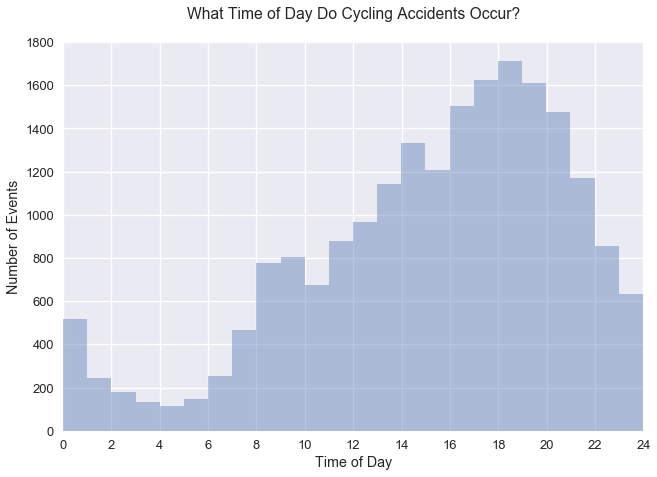

In [5]:
sb.set_context("talk")
p = sb.distplot(clean_data["time"], kde=False, bins=24)
p.set(xlim=(0,24), xlabel="Time of Day", ylabel="Number of Events", 
      title="What Time of Day Do Cycling Accidents Occur?\n")
plt.show(p.set_xticks(np.arange(0,25,2)))

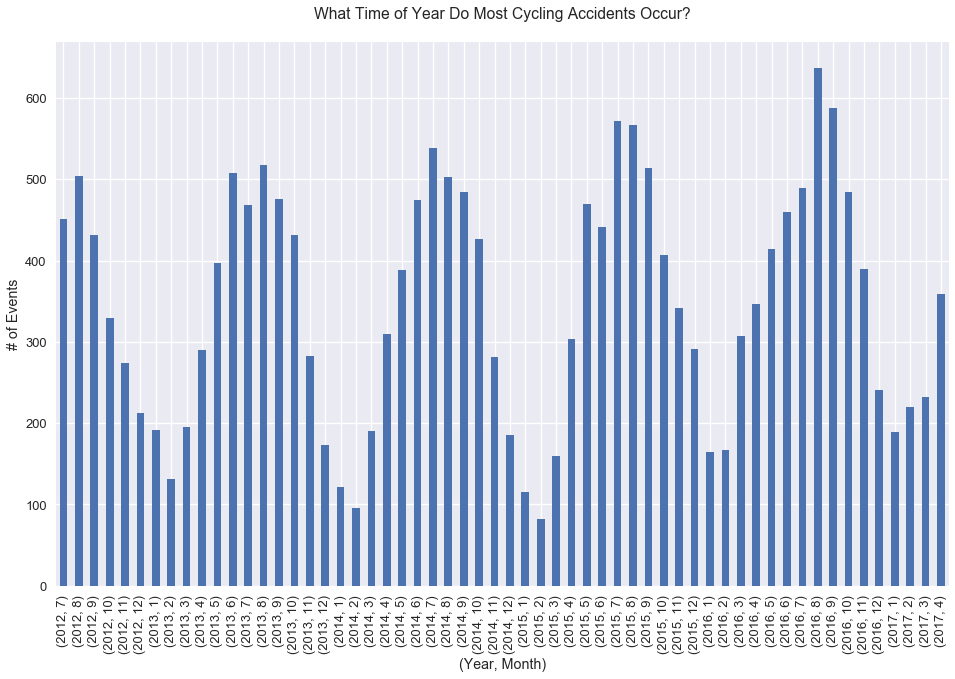

In [6]:
_ = clean_data.groupby([clean_data["date"].dt.year, clean_data["date"].dt.month])["date"].count()[:-1]\
.plot(kind="bar", figsize=(16,10)).set(title="What Time of Year Do Most Cycling Accidents Occur?\n", 
                                       xlabel="(Year, Month)", ylabel="# of Events")

In [7]:
#As reported by: http://www.nyc.com/visitor_guide/weather_facts.75835/
ny_seasons = ["Winter", "Winter", "Spring", "Spring", "Spring", "Summer", "Summer", "Summer", "Fall", "Fall", "Fall", "Winter"]
d = clean_data.groupby([clean_data["date"].dt.year, clean_data["date"].dt.month])["date"].count()[:-1]
d = pd.DataFrame(d)
d.columns = ["ct"]
d["year"] = [i[0] for i in d.index]
d["month"] = [i[1] for i in d.index]
d["season"] = [ny_seasons[i-1] for i in d["month"]]
d.index=np.arange(0,len(d))

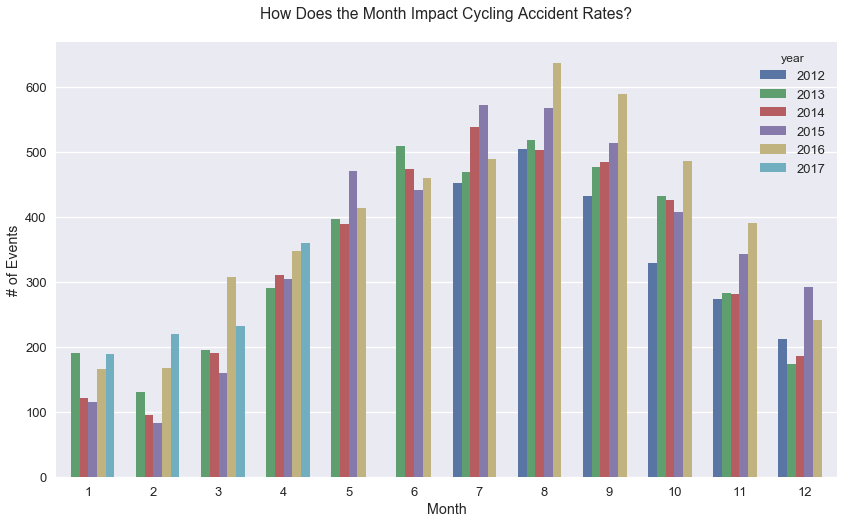

In [8]:
plt.figure(figsize=(14, 8))
_ = sb.barplot(x=d["month"], y=d["ct"], hue=d["year"])\
    .set(xlabel="Month", ylabel="# of Events",
         title="How Does the Month Impact Cycling Accident Rates?\n")

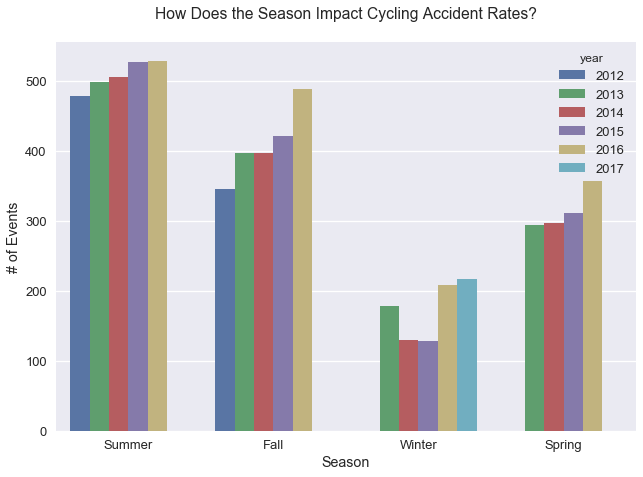

In [9]:
season_ct = d[:-2].copy()
season_ct["year"] = [i[0]+1 if i[1] == 12 else i[0] for i in zip(season_ct["year"], season_ct["month"])]
_ = sb.barplot(x="season", y="ct", hue="year", data=season_ct, ci=None)\
    .set(xlabel="Season", ylabel="# of Events", title="How Does the Season Impact Cycling Accident Rates?\n")

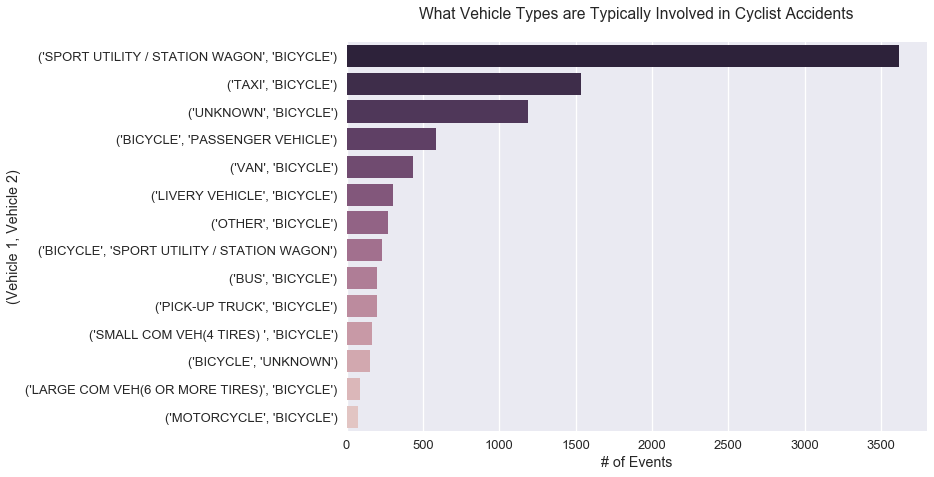

In [10]:
top_veh = clean_data.groupby([clean_data["vehicle_type_code1"], clean_data["vehicle_type_code2"]])["unique_key"].count()
top_veh = top_veh.sort_values(ascending=0)[1:15]
top_veh = pd.DataFrame(top_veh)
top_veh["vehicle_type_code1"] = top_veh.index
#plot
_ = sb.barplot(top_veh["unique_key"], top_veh["vehicle_type_code1"],\
           palette=sb.cubehelix_palette(15, reverse=True))\
.set(title="What Vehicle Types are Typically Involved in Cyclist Accidents\n", 
     xlabel='# of Events', ylabel='(Vehicle 1, Vehicle 2)')

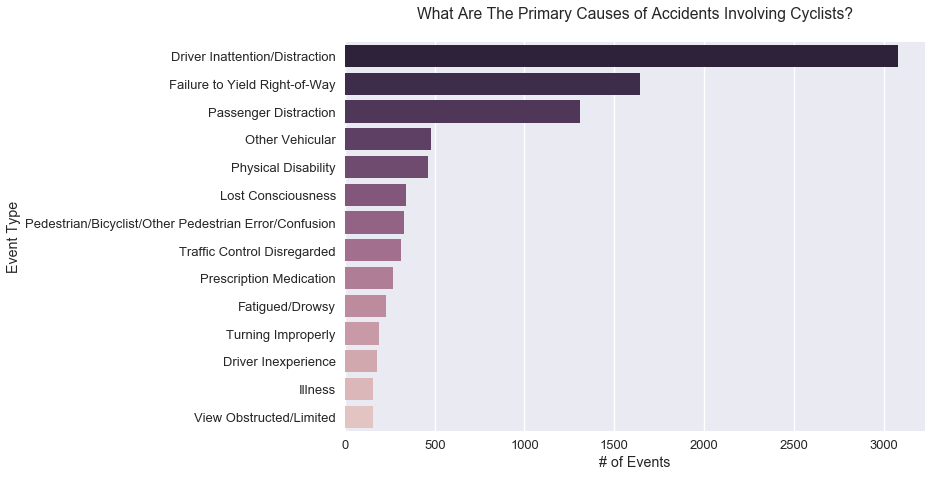

In [11]:
top_cf = clean_data.groupby("contributing_factor_vehicle_1")["unique_key"].count()
top_cf = top_cf.sort_values(ascending=0)[1:15]
top_cf = pd.DataFrame(top_cf)
top_cf["contributing_factor_vehicle_1"] = top_cf.index
#plot
_ = sb.barplot(top_cf["unique_key"], top_cf["contributing_factor_vehicle_1"],\
           palette=sb.cubehelix_palette(15, reverse=True))\
.set(title="What Are The Primary Causes of Accidents Involving Cyclists?\n", 
     xlabel='# of Events', ylabel='Event Type')